<a href="https://colab.research.google.com/github/aida-wofford/Carmen/blob/main/Tesis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#TESIS

### Instalación de versiones necesarias de dependencias.

In [26]:
!pip install --force-reinstall jsonschema==3.2.0

  Using cached jsonschema-3.2.0-py2.py3-none-any.whl (56 kB)
  Using cached six-1.16.0-py2.py3-none-any.whl (11 kB)
  Using cached setuptools-58.2.0-py3-none-any.whl (946 kB)
  Using cached pyrsistent-0.18.0-cp37-cp37m-manylinux1_x86_64.whl (119 kB)
  Using cached attrs-21.2.0-py2.py3-none-any.whl (53 kB)
  Using cached importlib_metadata-4.8.1-py3-none-any.whl (17 kB)
  Using cached zipp-3.6.0-py3-none-any.whl (5.3 kB)
  Using cached typing_extensions-3.10.0.2-py3-none-any.whl (26 kB)
  Attempting uninstall: zipp
    Found existing installation: zipp 3.6.0
    Uninstalling zipp-3.6.0:
      Successfully uninstalled zipp-3.6.0
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 3.10.0.2
    Uninstalling typing-extensions-3.10.0.2:
      Successfully uninstalled typing-extensions-3.10.0.2
  Attempting uninstall: six
    Found existing installation: six 1.16.0
    Uninstalling six-1.16.0:
      Successfully uninstalled six-1.16.0
  Attempting unin

In [27]:
!pip install spectres
!pip install pandas
!pip install specutils
!pip install astroquery
!pip install git+https://github.com/karllark/dust_extinction.git #Importamos el paquete necesario para hacer la corrección por polvo.

  Cloning https://github.com/karllark/dust_extinction.git to /tmp/pip-req-build-yau2h43p
  Running command git clone -q https://github.com/karllark/dust_extinction.git /tmp/pip-req-build-yau2h43p
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


In [28]:
import warnings, numpy as np
warnings.filterwarnings("ignore", category = np.VisibleDeprecationWarning)
warnings.filterwarnings("ignore", category = RuntimeWarning)
from astropy import units as u
from matplotlib import pyplot as plt
%matplotlib inline
from astropy import coordinates as coords
from astroquery.ned import Ned
from astroquery.irsa_dust import IrsaDust
from dust_extinction.parameter_averages import CCM89 # Importamos el modelo de Cardelli, Clayton & Mathis (1989) con A_V = 1 y R_V = 3.1 
from scipy.optimize import curve_fit
import numpy as np
import pandas as pd
from spectres import spectres
from matplotlib.pyplot import figure

###Models and observations

In [29]:
path='https://raw.githubusercontent.com/aida-wofford/Carmen/main/'

In [30]:
galaxies = ['NGC-1512','NGC-1566','M-51']# M-51 = NGC-5194
clusters = ['YSC1','YSC2']

### Define function that uses astroquery to obtain redshift of targets.

In [31]:
def redshift(target):
  result_table = Ned.query_object(target)
  z = result_table['Redshift'][0]
  return z
  
# Example, NGC 1512
print('z=', redshift("NGC 1512"))

z= 0.002995


### Define function to smooth the observed spectra and smoothing factor.

In [32]:
# Define smoothing function
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth
    
sf=5 #smoothing factor

###Create wavelength array to match sampling of model array.

In [33]:
# Model filename.
model = 'v94_z020_10Myr.ifaspec1'

# First age available
t0 = .10000E+05

# Load model
data = np.loadtxt(path + model, skiprows = 6, delimiter = "       ")
t, x, logy, yrec = np.transpose(data)

# Select portion of wavelength array corresponding to t0 and the range between 1150 and 1700 Angstroms.
x99 = x[np.nonzero((t == t0) & (x >= 1150.) & (x <= 1700.))]

###Define function to load and fix observations (correct for redshift, resample and smooth).

In [34]:
def fix_obs(galaxy, cluster, xarray):
  #Load observations and correct for redshift
  z=redshift(galaxy)
  x130_rectified = np.genfromtxt(path+galaxy+'-'+cluster+'_G130M_normspec_wLya.dat', usecols=0) / (1 + z)
  y130_rectified = np.genfromtxt(path+galaxy+'-'+cluster+'_G130M_normspec_wLya.dat', usecols=4)
  x160_rectified = np.genfromtxt(path+galaxy+'-'+cluster+'_G160M_normspec_wLya.dat', usecols=0) / (1 + z)
  y160_rectified = np.genfromtxt(path+galaxy+'-'+cluster+'_G160M_normspec_wLya.dat', usecols=4)
  #Resample observations
  y130_resampled = spectres(xarray, x130_rectified, y130_rectified, fill=0.)
  y160_resampled = spectres(xarray, x160_rectified, y160_rectified, fill=0.)
  #Smooth observations
  y130_smoothed = smooth(y130_resampled, sf)
  y160_smoothed = smooth(y160_resampled, sf)
  return y130_resampled, y160_resampled, y130_smoothed, y160_smoothed

###Define function to average in the overlapping region.

In [35]:
def merge(galaxy, cluster):
# Set necesart variables
  y130resampled = fix_obs(galaxy, cluster, x99)[0]
  y160resampled = fix_obs(galaxy, cluster, x99)[1]
  y130smoothed = fix_obs(galaxy, cluster, x99)[2]
  y160smoothed = fix_obs(galaxy, cluster, x99)[3]

# Mininum G160M wavelength with non-zero flux. 
  y160min=min(x99[np.nonzero((x99 < 1450.) & (y160resampled > 0.))])

# Number of G160M wavelength points with non-zero fluxes
  n160=len(x99[np.nonzero(x99 >= y160min)])

# Maximum G130M wavelength with non-zero flux.
  y130max=max(x99[np.nonzero((x99 < 1450.) & (y130resampled > 0.))])

# Number of G130M wavelength points with non-zero fluxes (except for segment gap)
  n130=len(x99[np.nonzero(x99 <= y130max)])

# Number of wavelength points in overlapping region between G130M and G160M.
  noverlap=len(x99[np.nonzero((x99 >= y160min) & (x99 <= y130max))])


# Index of G160M array where non-zero fluxes start.
  y_index_160_overlap_lo = np.where(x99 == y160min)

# Index of G160M array where overlap region ends.
  y_index_160_overlap_hi = np.where(x99 == y130max)

# Let y be the G130M + G160M spectrum of YSC1. The flux of the overlapping region 
# will be the average between the G130M and G160M fluxes. 
  y=[]

# We fill in the blue part of the merged array.
  for i in range(n130 - noverlap):
      y.append(y130resampled[i])


# We fill overlapping region of the merged array.
  for i in range(noverlap):
      y.append( (y130resampled[n130 - noverlap + i] + 
                y160resampled[y_index_160_overlap_lo[0] + i][0] ) / 2 )
        
# We fill the red part of the merged array.
  for i in range(n160 - noverlap):
      y.append( y160resampled[y_index_160_overlap_hi[0] + i])

# Smooth
  y_smooth = smooth(y,sf)
  return y_smooth

###Automatic method of obtaining extinctions.

In [36]:
def extincion(galaxy):
  #Have the `coords` module automatically look up the coordinates from the name of the source 
  pos = coords.SkyCoord.from_name(galaxy)
  table = IrsaDust.get_extinction_table(pos)

  A_B = table['A_SandF'][table['Filter_name'] == 'CTIO B'] # extinción Galáctica en la banda B
  A_V = table['A_SandF'][table['Filter_name'] == 'CTIO V'] # extinción Galáctica en la banda V
  ebvmw = A_B - A_V # exceso de color E(B-V) de la Vía Láctea (Milky Way)

  # Definimos el modelo de enrojecimiento debido al polvo
  ext = CCM89(Rv=3.1)
  return ebvmw, ext


###Define function for Unextinguished flux

In [37]:
def ufluxx(galaxy,cluster,ebvmw,ext,z):
  path='https://raw.githubusercontent.com/aida-wofford/Carmen/main/'
  data = np.loadtxt(path+galaxy+'-'+cluster+'_ssp_up_maskedSpectrum.txt', skiprows = 7)
  x, y, dy, mask = np.transpose(data)

  wave=[]
  flux=[]

  wave = x * u.AA # longitud de onda
  flux = y * 10**-15 * u.Unit('erg cm-2 s-1 AA-1') # flujo


  uflux = flux / ext.extinguish(1/wave.to(u.micron), Ebv=ebvmw)  #flujo corregido, uflux, usando el exceso de color ebvmw

  wave_rest = wave / (1 + z) #Corrección por corrimiento al rojo de la galaxia que se está moviendo radialmente respecto al observador.
  return x,y,wave,flux,wave_rest,uflux

### Define factor function 

In [61]:
def factor(uflux,y_lin,wave):
  return uflux[1500].value / y_lin[1500]

###Set up plotting


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outs

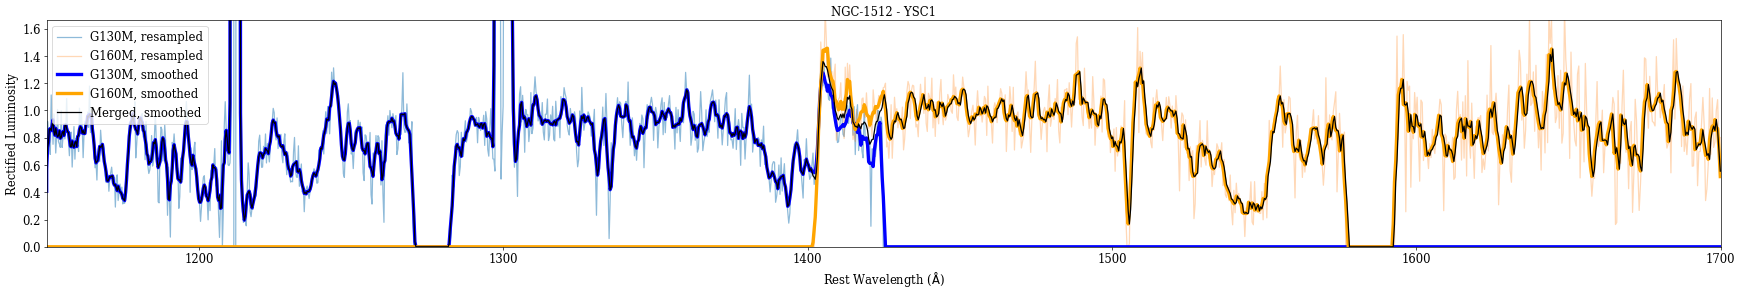

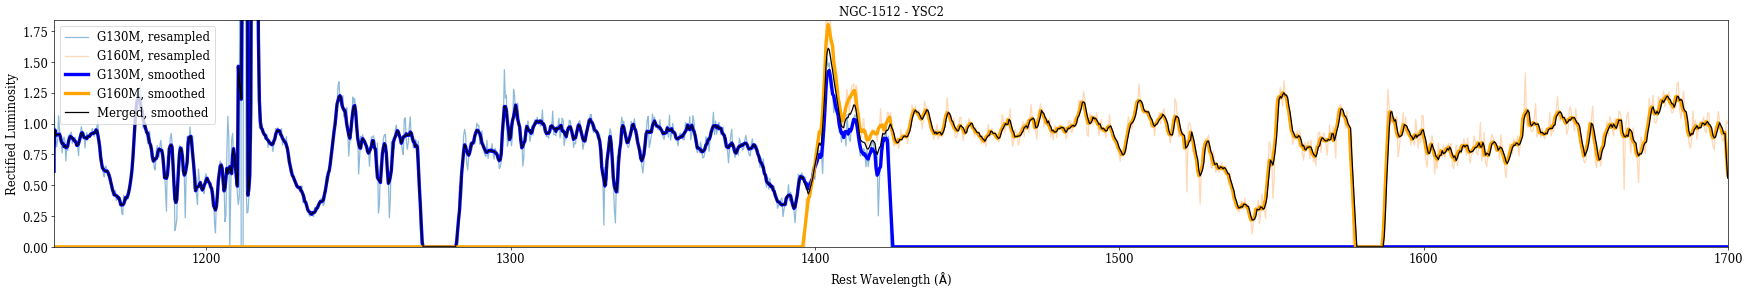

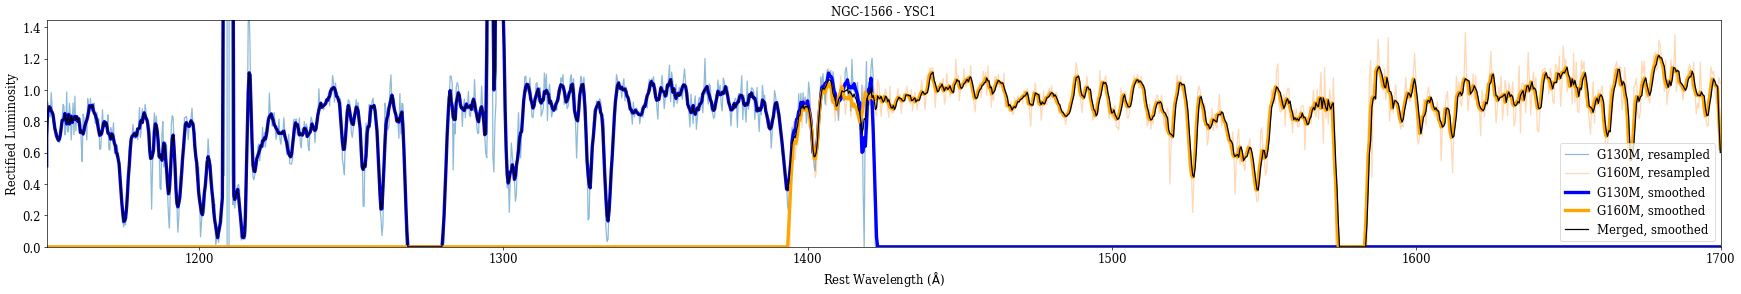

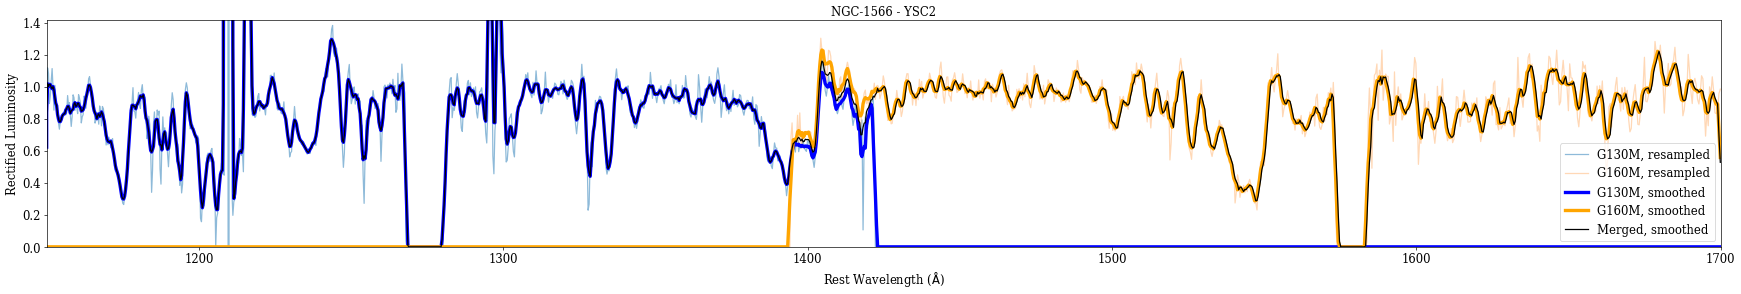

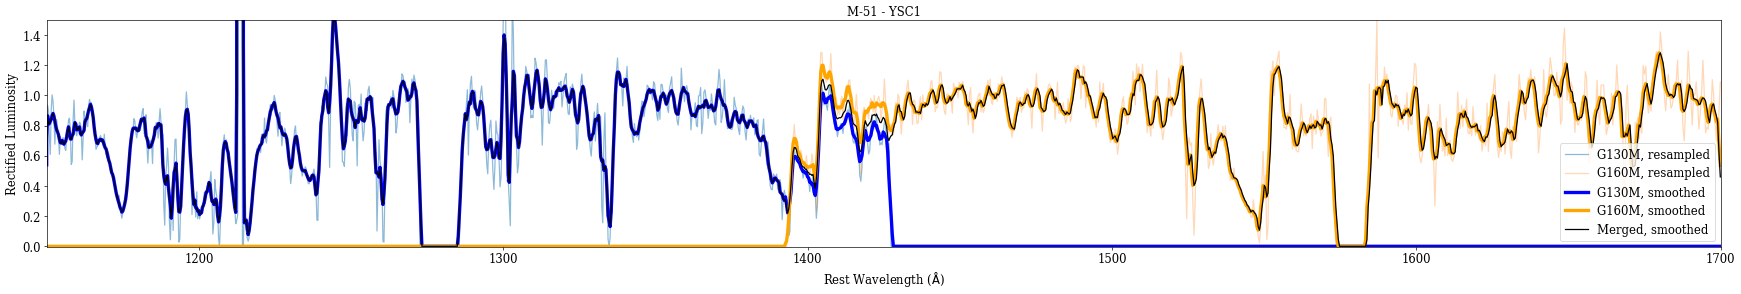

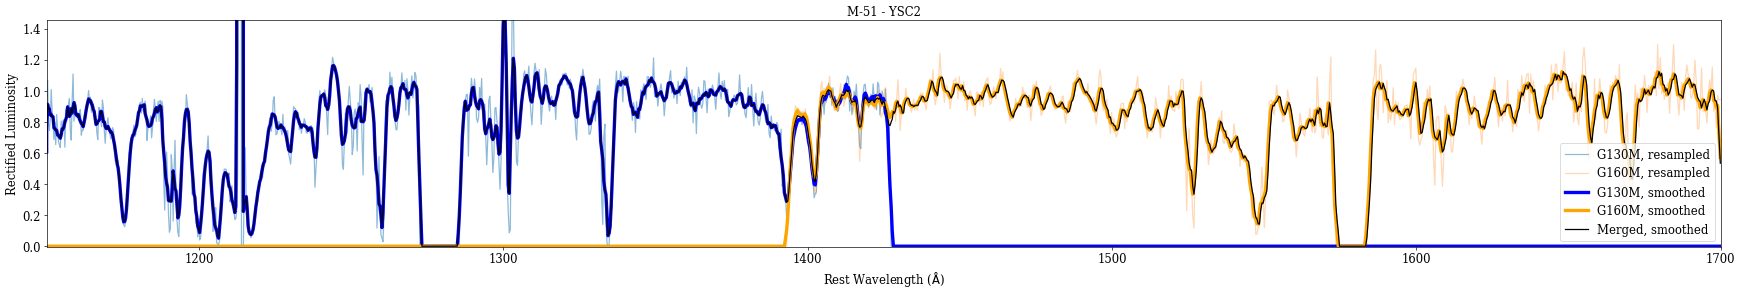

In [38]:
# Set plot fontsize
size=14
wg='regular'
font = {'family' : 'serif',
        'weight' : wg,
        'size'   : size}
plt.rc('font', **font)

# Plot in this notebook
%matplotlib inline

for igalaxy in range(3):
  galaxy = galaxies[igalaxy]
  for icluster in range(2):
    cluster = clusters[icluster]

# Load variables to be plotted
    y130resampled = fix_obs(galaxies[igalaxy], clusters[icluster], x99)[0]
    y160resampled = fix_obs(galaxies[igalaxy], clusters[icluster], x99)[1]
    y130smoothed = fix_obs(galaxies[igalaxy], clusters[icluster], x99)[2]
    y160smoothed = fix_obs(galaxies[igalaxy], clusters[icluster], x99)[3]
    ysmoothed = merge(galaxies[igalaxy], clusters[icluster])
# Plot result for YSC1
    fig, axes = plt.subplots(figsize=(36,5), dpi=60)

# Set plot title
    plt.title(galaxy + ' - ' + cluster, fontsize = size)

# Set limits of horizontal axis
    plt.xlim(1150.,1700.)

# Set label of horizontal axis
    plt.xlabel(r'Rest Wavelength ($\rm{\AA}$)', fontsize=size)

# Set limits of vertical axis
    good_x = np.where(x99 >= 1320) 
    plt.ylim(min(y130resampled[good_x]), 1.2*max(y130resampled[good_x]))

# Set label of vertical axis
    plt.ylabel('Rectified Luminosity', fontsize=size)

# Change font of tick axis labels
    for tick in axes.xaxis.get_major_ticks():
                tick.label.set_fontsize(14)
    for tick in axes.yaxis.get_major_ticks():
                tick.label.set_fontsize(14)

# Plot resampled, unsmoothed data
    plt.plot(x99, y130resampled, alpha=0.5, label='G130M, resampled')
    plt.plot(x99, y160resampled, alpha=0.3, label='G160M, resampled')

# Overlay resampled, smoothed data
    plt.plot(x99, y130smoothed, color='blue', alpha=1, 
             label='G130M, smoothed', linewidth=4)
    plt.plot(x99, y160smoothed, color='orange', alpha=1, 
             label='G160M, smoothed', linewidth=4)

# Overlay merged, smoothed data
    plt.plot(x99, ysmoothed, color='black', alpha=1, label='Merged, smoothed',
             linestyle='-')

# Mark positions of lines of interest
    #plt.axvline(x=1334.53,color='black',alpha=1,zorder=0, linestyle='--')
    #plt.axvline(x=1393.76,color='black',alpha=1,zorder=0, linestyle='--')
    #plt.axvline(x=1402.77,color='black',alpha=1,zorder=0, linestyle='--')

# Add legend
    plt.legend(fontsize=size)


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outs

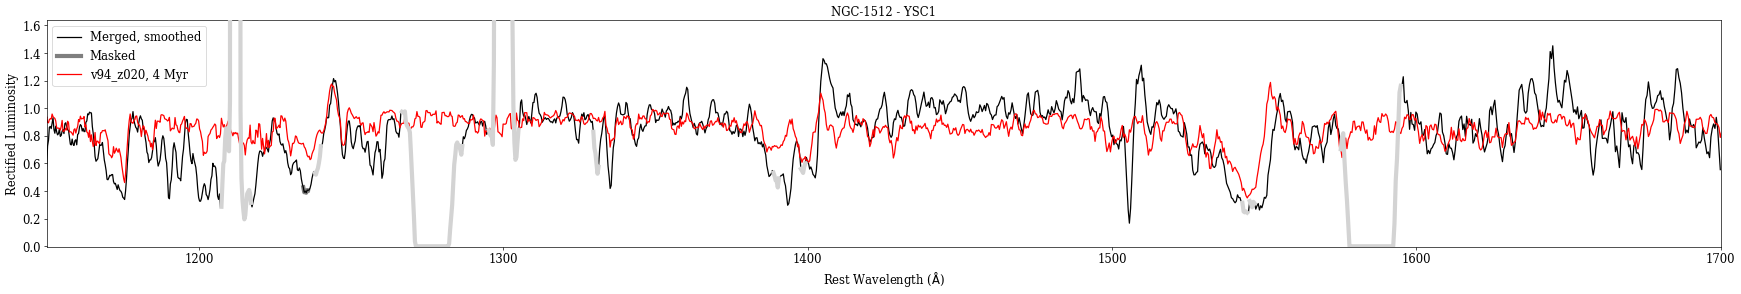

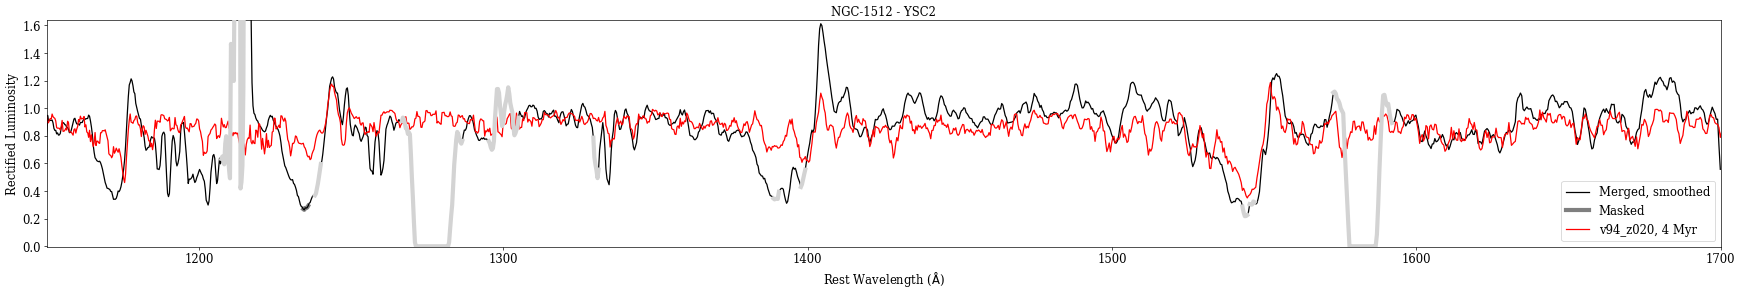

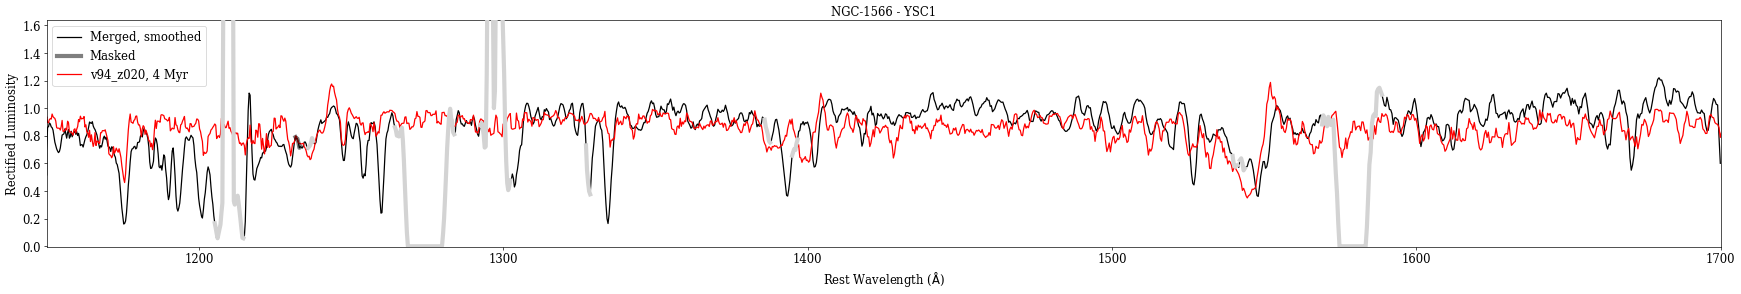

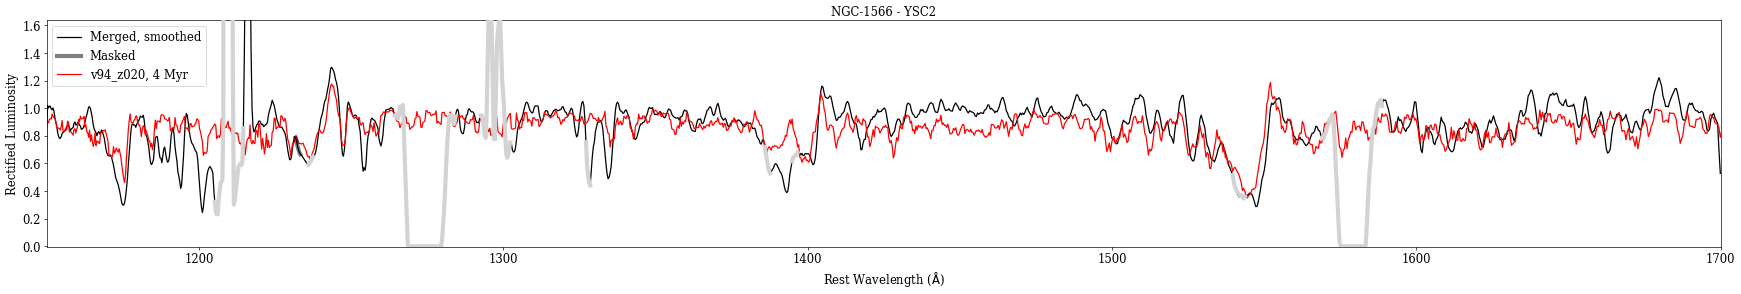

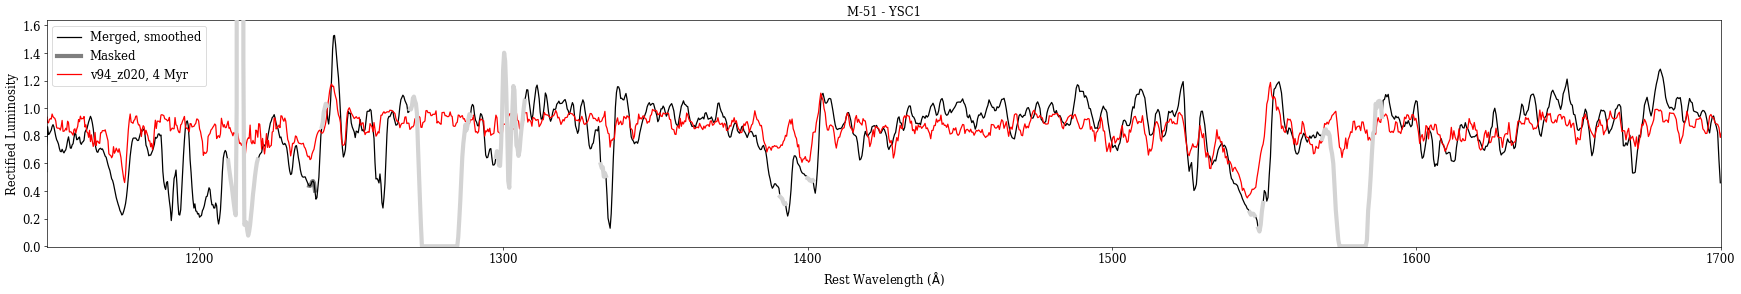

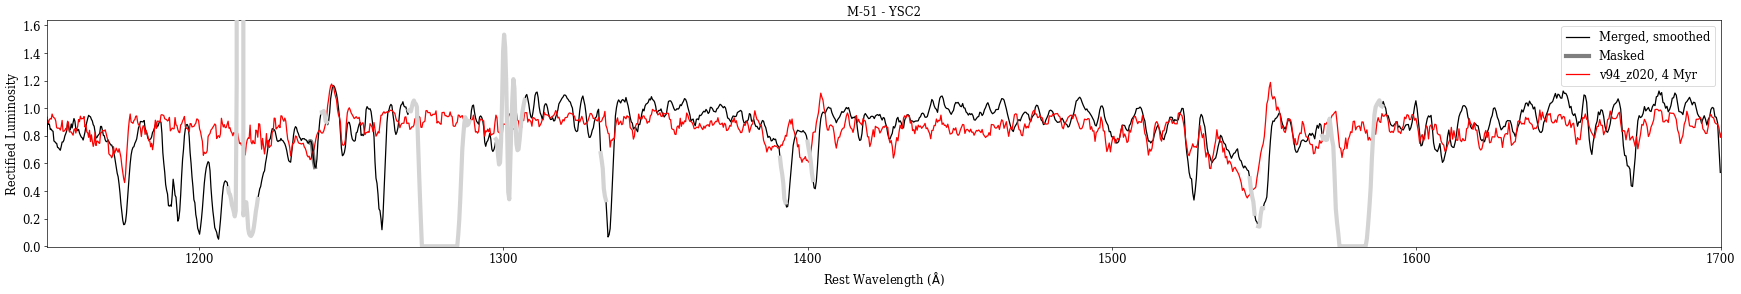

In [39]:
# Line list for masks
#Milky Way
mw=[1238.82, 1242.80,# N V
    1334.53,
    1393.76, 1402.77,# Si IV
    1548.19, 1550.77,# C IV
    ]
#geocoronal
geo=[1216., 
     1304.]

xlo=1500
xhi=1580

# Models
model=['v94_z020', 'v94_z040']

# Initial time step of models in Myr
t0 = .1e5 

# Ages of interest
ages = [1e6, 2e6, 3e6, 4e6, 5e6, 6e6, 7e6, 8e6, 9e6, 10e6]# in Myr
#        0     1   2     3   4

iage=3
imodel=0

# Load data of models to be compared into variables
data=np.loadtxt(path + model[imodel] + '_10Myr.ifaspec1', skiprows=6, delimiter="       ")
time, wave, logL, norm = np.transpose(data)
good_indices = np.where(time == ages[iage] + t0)
x=wave[good_indices]
y=norm[good_indices]

for igalaxy in range(3):
  galaxy = galaxies[igalaxy]
  z=redshift(galaxy)
  for icluster in range(2):
    cluster = clusters[icluster]

# Load variables to be plotted
    ysmoothed = merge(galaxies[igalaxy], clusters[icluster])
# Plot result for YSC1
    fig, axes = plt.subplots(figsize=(36,5), dpi=60)

# Set plot title
    plt.title(galaxy + ' - ' + cluster, fontsize = size)

# Set limits of horizontal axis
    plt.xlim(1150.,1700.)

# Set label of horizontal axis
    plt.xlabel(r'Rest Wavelength ($\rm{\AA}$)', fontsize=size)

# Set limits of vertical axis
    good_x = np.where(x99 >= 1320) 
    plt.ylim(min(y130resampled[good_x]), 1.35*max(y130resampled[good_x]))

# Set label of vertical axis
    plt.ylabel('Rectified Luminosity', fontsize=size)

# Change font of tick axis labels
    for tick in axes.xaxis.get_major_ticks():
                tick.label.set_fontsize(14)
    for tick in axes.yaxis.get_major_ticks():
                tick.label.set_fontsize(14)

# Overlay merged, smoothed data
    plt.plot(x99, ysmoothed, color='black', alpha=1, label='Merged, smoothed',
             linestyle='-')

# Mask positions of contaminating MW lines
    for i in range(len(mw)):
      bad=np.nonzero(abs(x99 - mw[i]/(1+z)) <= 1.)
      if i==0:
        plt.plot(x99[bad], ysmoothed[bad], color='black', linewidth='5', alpha=0.5, 
         zorder=10, label='Masked')
      else:
        plt.plot(x99[bad], ysmoothed[bad], color='lightgrey', linewidth='5', alpha=1, 
         zorder=10)    

    for i in range(len(geo)):
      bad=np.nonzero(abs(x99 - geo[i]/(1+z)) <= 5.)
      plt.plot(x99[bad], ysmoothed[bad], color='lightgrey', linewidth='5', alpha=1, 
         zorder=10)

#Segment gap 1
    ybad=np.nonzero((x99 < 1300) & (ysmoothed==0.))
    yave_gap1=(max(x99[ybad])+min(x99[ybad]))/2
    ybad=np.nonzero(abs(x99 - yave_gap1) <= 10.)
    plt.plot(x99[ybad], ysmoothed[ybad], color='lightgrey', linewidth='5', alpha=1, 
         zorder=10)

#Segment gap 2
    ybad=np.nonzero((x99 > 1500) & (ysmoothed==0.))
    yave_gap2=(max(x99[ybad])+min(x99[ybad]))/2
    ybad=np.nonzero(abs(x99 - yave_gap2) <= 10.)
    plt.plot(x99[ybad], ysmoothed[ybad], color='lightgrey', linewidth='5', alpha=1, 
         zorder=10)

# Overlay model
    plt.plot(x, smooth(y,5), color='red', label=model[imodel]+', '+str(iage+1)+' Myr')
# Add legend
    plt.legend(fontsize=size)

#plt.savefig(galaxies[igalaxy]+'-'+clusters[icluster], bbox_inches = 'tight',dpi=100)

###New spectra

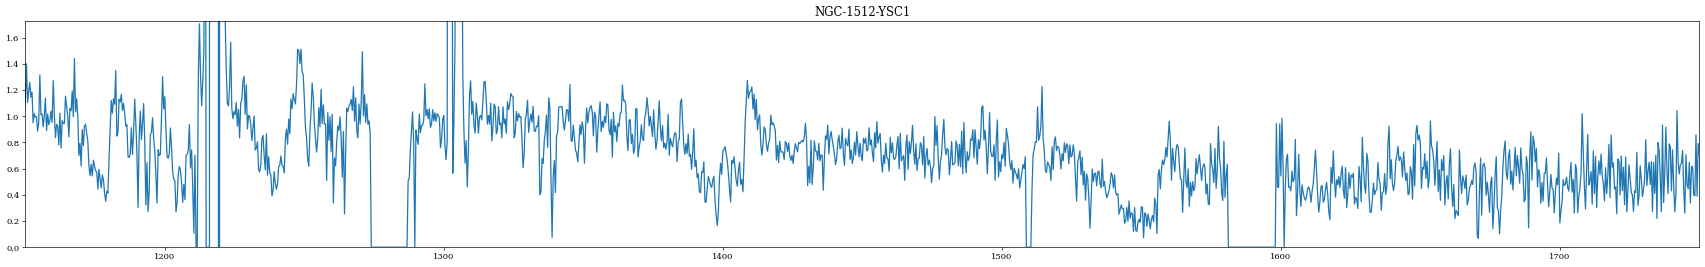

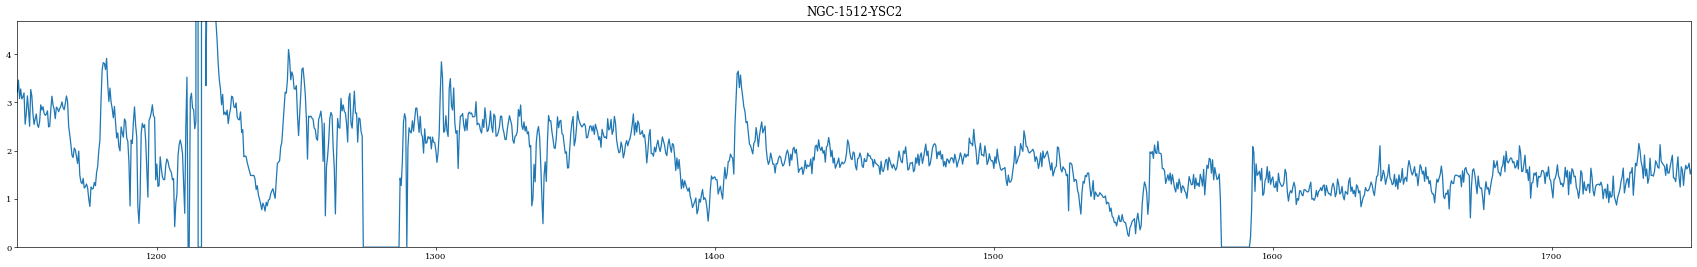

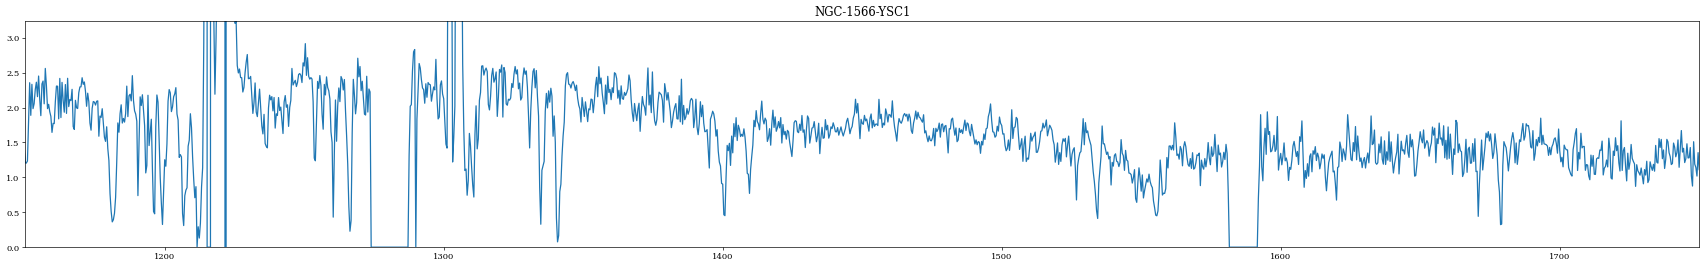

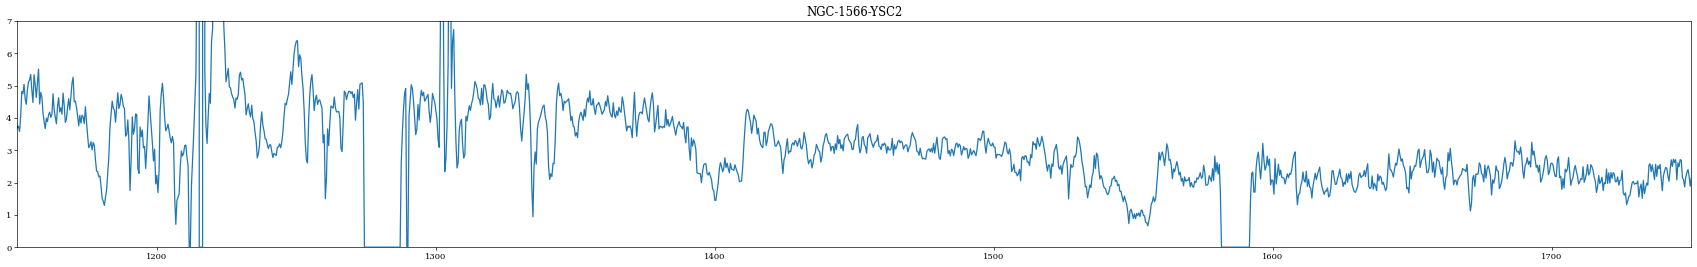

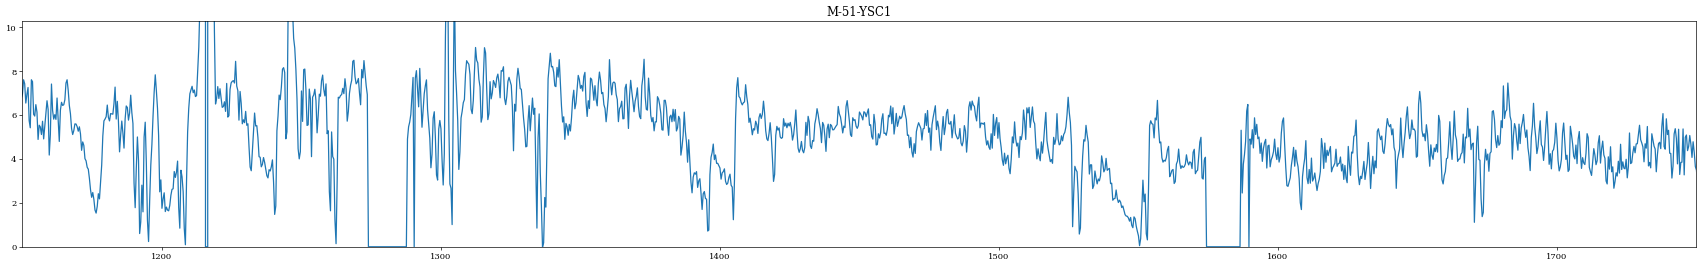

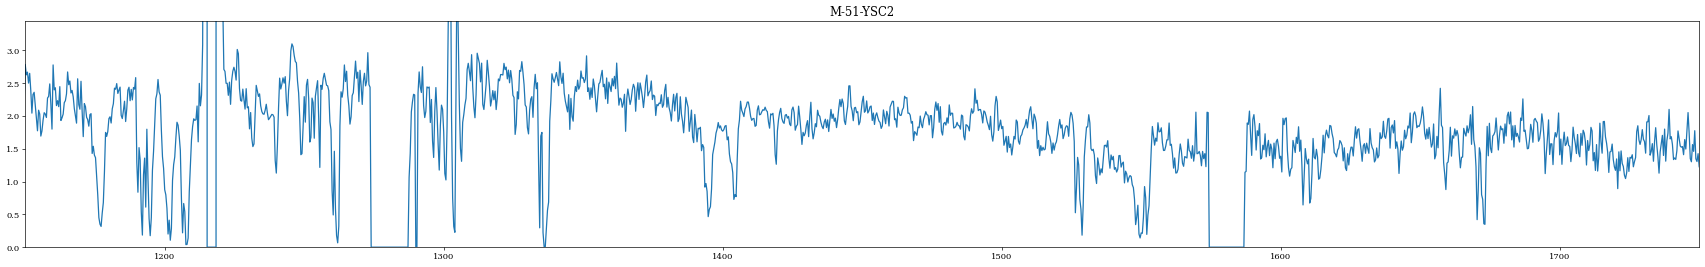

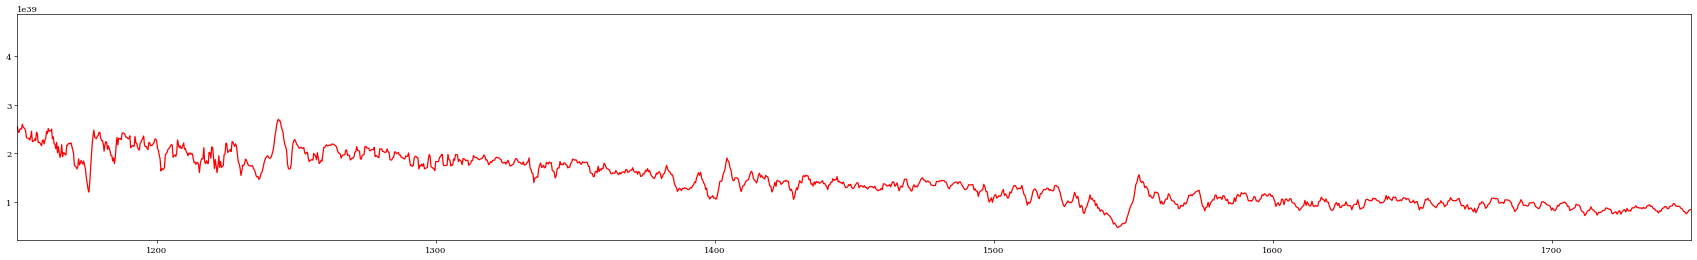

In [40]:
import numpy as np
# Models
model=['v94_z020', 'v94_z040']

# Initial time step of models in Myr
t0 = .1e5 

# Ages of interest
ages = [1e6, 2e6, 3e6, 4e6, 5e6, 6e6, 7e6, 8e6, 9e6, 10e6]# in Myr

iage=3
imodel=0

# Load data of models to be compared into variables
data=np.loadtxt(path + model[imodel] + '_10Myr.ifaspec1', skiprows=6, delimiter="       ")
time, wave, logL, norm = np.transpose(data)
good_indices = np.where(time == ages[iage] + t0)
x_mod=wave[good_indices]
y_mod=logL[good_indices]

y_lin=[]

for ix in range(len(y_mod)):
  y_lin = np.append(y_lin, 10**y_mod[ix])

for igalaxy in range(3):
  galaxy = galaxies[igalaxy]
 # z=redshift(galaxy)
  for icluster in range(2):
    cluster = clusters[icluster]

# Load model
    data = np.loadtxt(path + galaxy + '-' + cluster + '_ssp_up_maskedSpectrum.txt', skiprows = 7)
    x, y, dy, mask = np.transpose(data)
    fig, axes = plt.subplots(figsize=(36,5), dpi=60)
    plt.plot(x,y)
    plt.xlim(1150,1750)
    goodpts = np.where(x < 1200)
    plt.ylim(min(y),1.2*max(y[goodpts]))
    plt.title(galaxy+ '-' + cluster,fontsize=14)
    plt.plot(x_mod, smooth(y_mod,5), color='red', label=model[imodel]+', '+str(iage+1)+' Myr') 



fig, axes = plt.subplots(figsize=(36,5), dpi=60)
plt.ylim(min(y_lin),max(y_lin[goodpts]))
plt.xlim(1150,1750)
plt.plot(x_mod, smooth(y_lin,5), color='red', label=model[imodel]+', '+str(iage+1)+' Myr') 

###New spectra with corrections + model

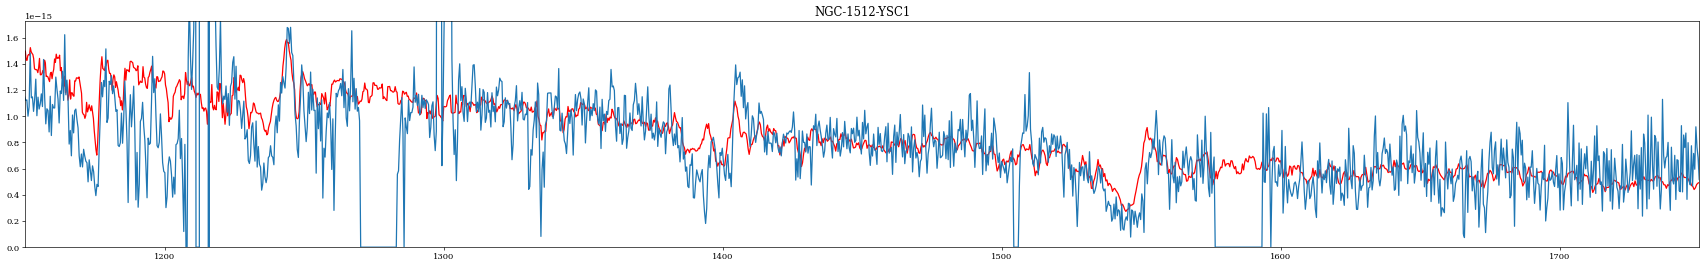

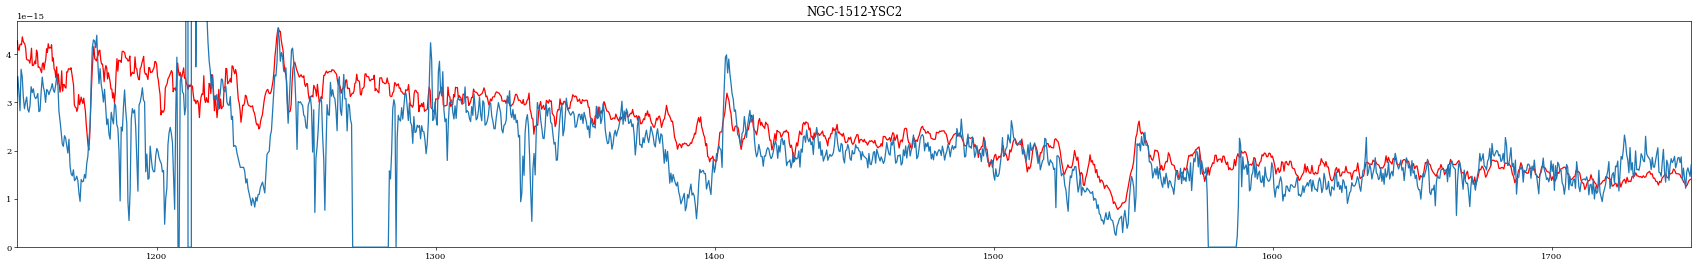

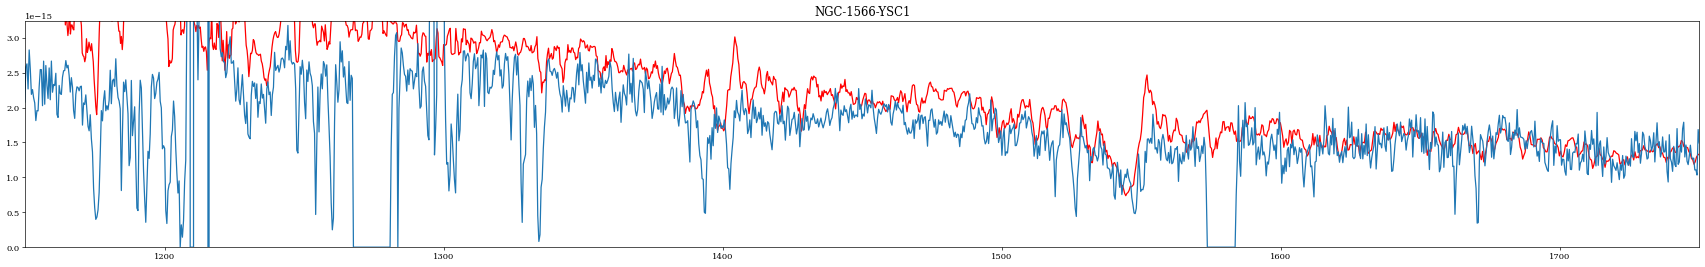

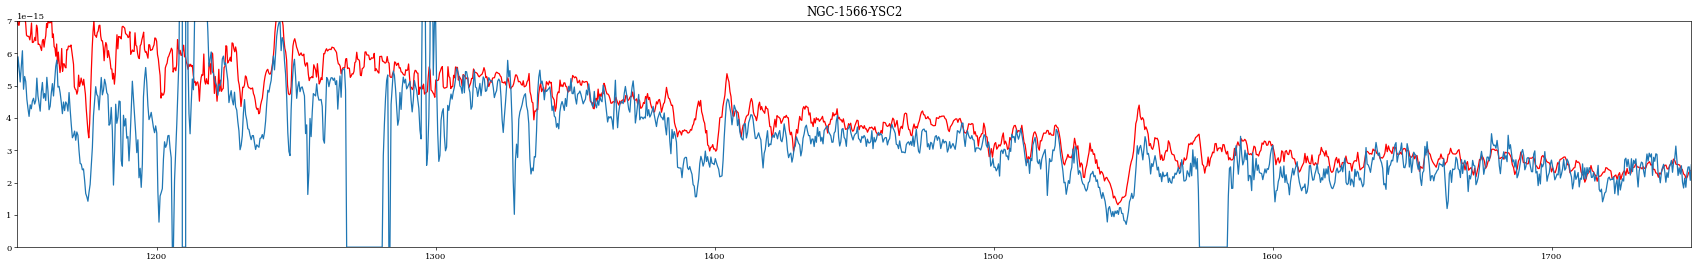

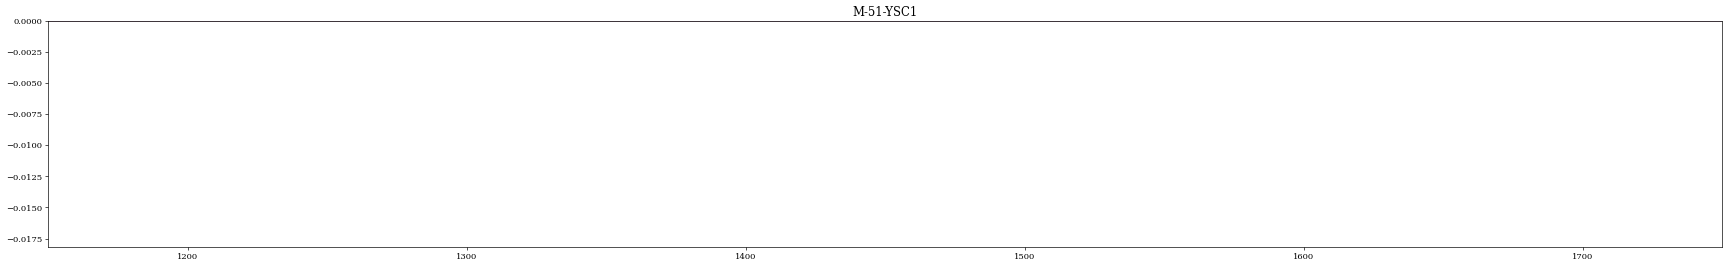

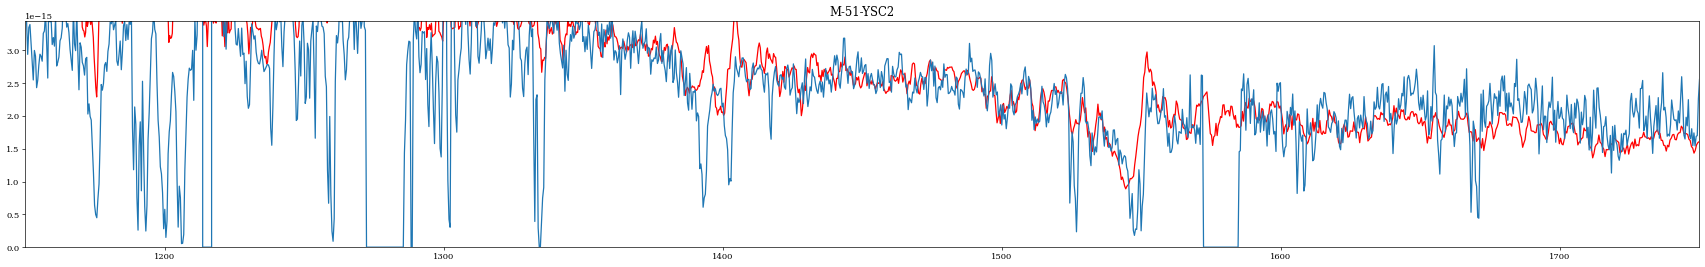

In [63]:
# Models
model=['v94_z020', 'v94_z040']

# Initial time step of models in Myr
t0 = .1e5 

# Ages of interest
ages = [1e6, 2e6, 3e6, 4e6, 5e6, 6e6, 7e6, 8e6, 9e6, 10e6]# in Myr

iage=3
imodel=0
f=0

# Load data of models to be compared into variables
y_lin=[]
data=np.loadtxt(path + model[imodel] + '_10Myr.ifaspec1', skiprows=6, delimiter="       ")
time, wave, logL, norm = np.transpose(data)
good_indices = np.where(time == ages[iage] + t0)
x_mod=wave[good_indices]
y_mod=logL[good_indices]

for ix in range(len(y_mod)):
  y_lin = np.append(y_lin, 10**y_mod[ix])

for igalaxy in range(3):
  galaxy = galaxies[igalaxy]
  z=redshift(galaxy)
  for icluster in range(2):
    cluster = clusters[icluster]
    ebvmw, ext = extincion(galaxy)
    x,y,wave,flux,wave_rest,uflux = ufluxx(galaxy,cluster,ebvmw,ext,z)
    fig, axes = plt.subplots(figsize=(36,5), dpi=60)
    goodpts = np.where(x < 1200)
    plt.ylim(min(y),1.2*1e-15*max(y[goodpts]))
    f=factor(uflux,y_lin,1500)
    plt.plot(x_mod, f*smooth(y_lin,5), color='red', label=model[imodel]+', '+str(iage+1)+' Myr')
    plt.plot(wave_rest,uflux)
    plt.xlim(1150,1750)
    plt.title(galaxy+ '-' + cluster,fontsize=14)

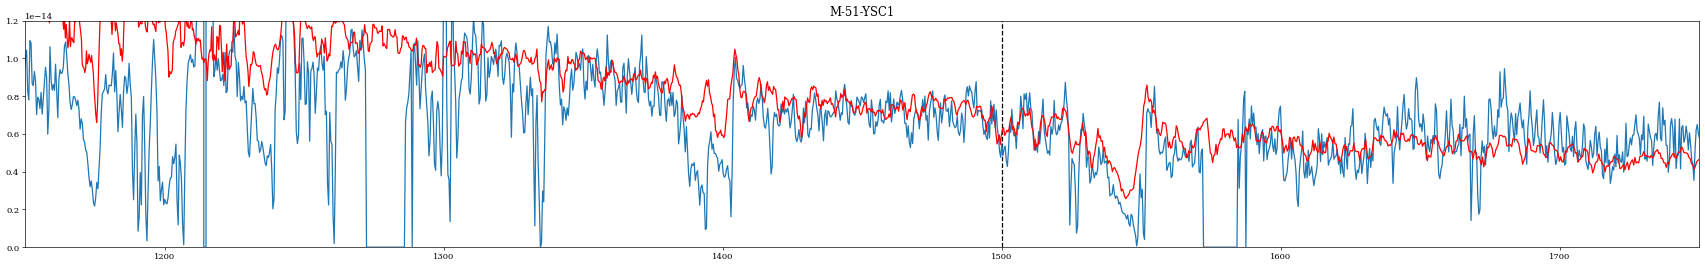

In [60]:
galaxy = galaxies[2]
z=redshift(galaxy)
cluster = clusters[0]
ebvmw, ext = extincion(galaxy)
x,y,wave,flux,wave_rest,uflux = ufluxx(galaxy,cluster,ebvmw,ext,z)
fig, axes = plt.subplots(figsize=(36,5), dpi=60)
plt.plot(wave_rest,uflux)
plt.plot(x_mod, 5.520158787199147e-54*smooth(y_lin,5), color='red', label=model[imodel]+', '+str(iage+1)+' Myr') 
plt.xlim(1150,1750)
goodpts = np.where(x < 1200)
plt.ylim(0,1.2e-14)
plt.title(galaxy+ '-' + cluster,fontsize=14)
plt.axvline(x=1500,color='black',alpha=1,zorder=0, linestyle='--')

In [49]:
y_lin[1500]

9.611916735173169e+38

In [62]:
galaxy = galaxies[2]
z=redshift(galaxy)
cluster = clusters[0]
ebvmw, ext = extincion(galaxy)
x,y,wave,flux,wave_rest,uflux = ufluxx(galaxy,cluster,ebvmw,ext,z)
factor(uflux,y_lin,1500)

5.520158787199147e-54

(1150.0, 1750.0)

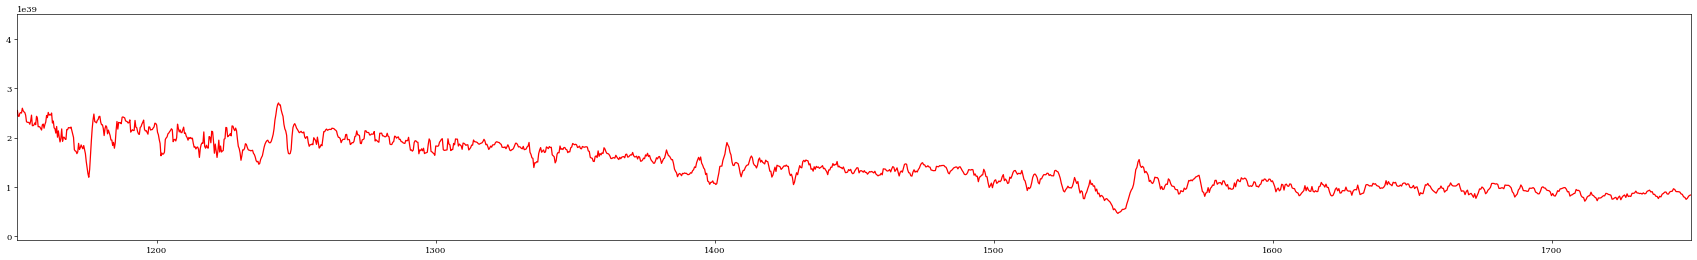

In [55]:
fig, axes = plt.subplots(figsize=(36,5), dpi=60)
plt.plot(x_mod, smooth(y_lin,5), color='red', label=model[imodel]+', '+str(iage+1)+' Myr') 
plt.xlim(1150,1750)